In [13]:
import pandas as pd
#import SeisBlast as sb
import numpy as np
import concurrent.futures
import src.preprocessing as pp

In [3]:
seisblast_files = '/home/bmelo/Quarry/Quarry-Blast/tomo/'

stations = pd.read_csv(
    seisblast_files + 'lists/Total_Stations_List.txt', 
    delimiter=' ',
    names=['sta', 'name','lat', 'lon', 'elevation', 'net', 'end'])

james_catalogue = pd.read_csv(seisblast_files + 'catalogues/quarry-blast-catalog-all.csv', sep = r'\s+')
james_bulletins_dirs = [
    '/mnt/REPO/QUARRY-BLASTS/BULLETINS/',
    '/mnt/REPO/QUARRY-BLASTS/QB-BULLETINS-2022-2024'
]

blasts = pd.read_csv(seisblast_files + 'seisblast/Eire_blasts_all-relocated.csv')
#merge with the relocated quarry blasts lists to get the relocated events
relocated_catalogue = pd.merge(james_catalogue, blasts, left_on='EVENT-ID', right_on='id-ev')
relocated_catalogue = relocated_catalogue.sort_values(by=['lon-quarry', 'lat-quarry']).reset_index(drop=True)
stations.tail(5)

,sta,name,lat,lon,elevation,net,end
269,STA,GR05,54.920728,-6.383008,108.0,EI,END
270,STA,GR06,54.949800,-6.976500,57.0,EI,END
271,STA,UHEL2,53.243374,-6.319330,355.0,EI,END
272,STA,USLI2,53.264694,-6.237059,148.6,EI,END
273,STA,UCRE2,53.198600,-6.292600,353.0,EI,END


Get into bulletin information of each event and make a list of event location, station and travel time

In [5]:
quarry_data = pd.DataFrame()

#first loop over the values of the relocated catalogue, make a list of events with all the picks
def process_event(index_row):
    index, row = index_row
    qry_id = row['quarry-ID'] if 'quarry-ID' in row else None
    ev_id = row['EVENT-ID']
    try:
        df, info = pp.list_picks(james_catalogue, james_bulletins_dirs, ev_id)
        origin_time = pd.to_datetime((relocated_catalogue.loc[index, 'DATE'] + ' ' + relocated_catalogue.loc[index, 'TIME']), format='%Y-%m-%d %H:%M:%S.%f')
        df['Ptime(s)'] = (df['time']['P'] - origin_time).dt.total_seconds()
        temp_df = pd.DataFrame({
            'quarry-lat': row['lat-quarry'],
            'quarry-lon': row['lon-quarry'],
            'sta': df['sta'],
            'Ptime(s)': df['Ptime(s)'],
            'ev_id': ev_id,
            'distkm': df['distkm'],
        })
        return temp_df
    except Exception as e:
        print(f"Error processing event {ev_id}: {e}")
        return None

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    results = list(executor.map(process_event, relocated_catalogue.iterrows()))

# Filter out None results and concatenate
quarry_data = pd.concat([df for df in results if df is not None], axis=0, ignore_index=True)
quarry_data.to_csv(seisblast_files + 'seisblast/quarry_data.csv', index=False)


In [8]:
quarry_data = pd.read_csv(seisblast_files + 'seisblast/quarry_data.csv')


In [ ]:
#group by quarry ID and station and calculate the median, std and count of the picks
quarry_data_group = quarry_data.dropna().groupby(['quarry-lat','quarry-lon','sta']).agg({'Ptime(s)': list, 'ev_id': list, 'distkm': list}).reset_index()
#quarry_data_group['Ptime(s)'] = quarry_data_group['Ptime(s)'].apply(lambda x: x if isinstance(x, list) else [x])
#calculate the median, std and count of the picks
quarry_data_group['median'] = quarry_data_group['Ptime(s)'].apply(lambda x: np.median(x))
quarry_data_group['std'] = quarry_data_group['Ptime(s)'].apply(lambda x: sum((i - sum(x)/len(x))**2 for i in x)/len(x))
quarry_data_group['count'] = quarry_data_group['Ptime(s)'].apply(lambda x: len(x))
quarry_data_group['closest-time'] = quarry_data_group.apply(lambda row: min(row['Ptime(s)'], key=lambda x: abs(x-row['median'])), axis=1)
quarry_data_group['closest-ev_id'] = quarry_data_group.apply(lambda row: row['ev_id'][row['Ptime(s)'].index(row['closest-time'])], axis=1)
#Instead of using the median time, which would not have a corresponding event ID, we use the event time closest to the median time
# #now i need to add information about the origin time and magnitude of the event
quarry_data_group['origin_time'] = quarry_data_group['closest-ev_id'].apply(lambda x: relocated_catalogue.loc[relocated_catalogue['EVENT-ID'] == x, 'DATE'].values[0] + ' ' + relocated_catalogue.loc[relocated_catalogue['EVENT-ID'] == x, 'TIME'].values[0])
quarry_data_group['mag'] = quarry_data_group['closest-ev_id'].apply(lambda x: relocated_catalogue.loc[relocated_catalogue['EVENT-ID'] == x, 'MAG(ML)'].values[0])


,quarry-lat,quarry-lon,sta,Ptime(s),ev_id,distkm,median,std,count,closest-time,closest-ev_id,origin_time,mag
0,51.536264,-9.586802,IMAC,"[8.46, 8.147, 8.316, 8.256, 8.329]","[dias2023onge, dias2023ymtl, dias2024eprl, dia...","[51.612237151338384, 48.86349856468489, 50.593...",8.316,0.010406,5,8.316,dias2024eprl,2024-03-06 12:00:09.714,0.33
1,51.536264,-9.586802,IMIC,"[22.59, 22.636, 22.312]","[dias2023onge, dias2024eprl, dias2024lbtt]","[134.77714668733677, 133.83310176012444, 133.2...",22.590,0.020486,3,22.590,dias2023onge,2023-07-26 11:23:24.460,0.58
2,51.536264,-9.586802,IP07,"[2.361, 2.531, 2.447, 2.58]","[dias2023ymtl, dias2024eprl, dias2024lbtt, dia...","[15.440527513863428, 15.09915908906463, 16.098...",2.489,0.006963,4,2.447,dias2024lbtt,2024-06-06 12:00:55.154,0.42
3,51.536264,-9.586802,ITIP,[32.226],[dias2023onge],[199.4748028062068],32.226,0.000000,1,32.226,dias2023onge,2023-07-26 11:23:24.460,0.58
4,51.536264,-9.586802,VAL,"[11.327, 11.207, 11.346, 11.246, 11.349]","[dias2023onge, dias2023ymtl, dias2024eprl, dia...","[65.59611112615809, 63.30327173874729, 64.6420...",11.327,0.003337,5,11.327,dias2023onge,2023-07-26 11:23:24.460,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,55.258600,-7.205738,DL31,[6.315],[dias2014bqzf],[39.15729341788136],6.315,0.000000,1,6.315,dias2014bqzf,2014-01-24 12:27:29.676,0.76
7264,55.258600,-7.205738,IAD33,[20.536],[dias2014gwcc],[121.37815802666742],20.536,0.000000,1,20.536,dias2014gwcc,2014-04-08 11:16:03.644,0.78
7265,55.258600,-7.205738,IDGL,"[4.959, 4.905, 4.495]","[dias2014bqzf, dias2014gwcc, dias2014thky]","[29.492230393936318, 29.15086196913752, 27.392...",4.905,0.042924,3,4.905,dias2014gwcc,2014-04-08 11:16:03.644,0.78
7266,55.258600,-7.205738,ILTH,[24.762],[dias2014thky],[146.67277993977163],24.762,0.000000,1,24.762,dias2014thky,2014-10-02 10:39:38.805,0.58


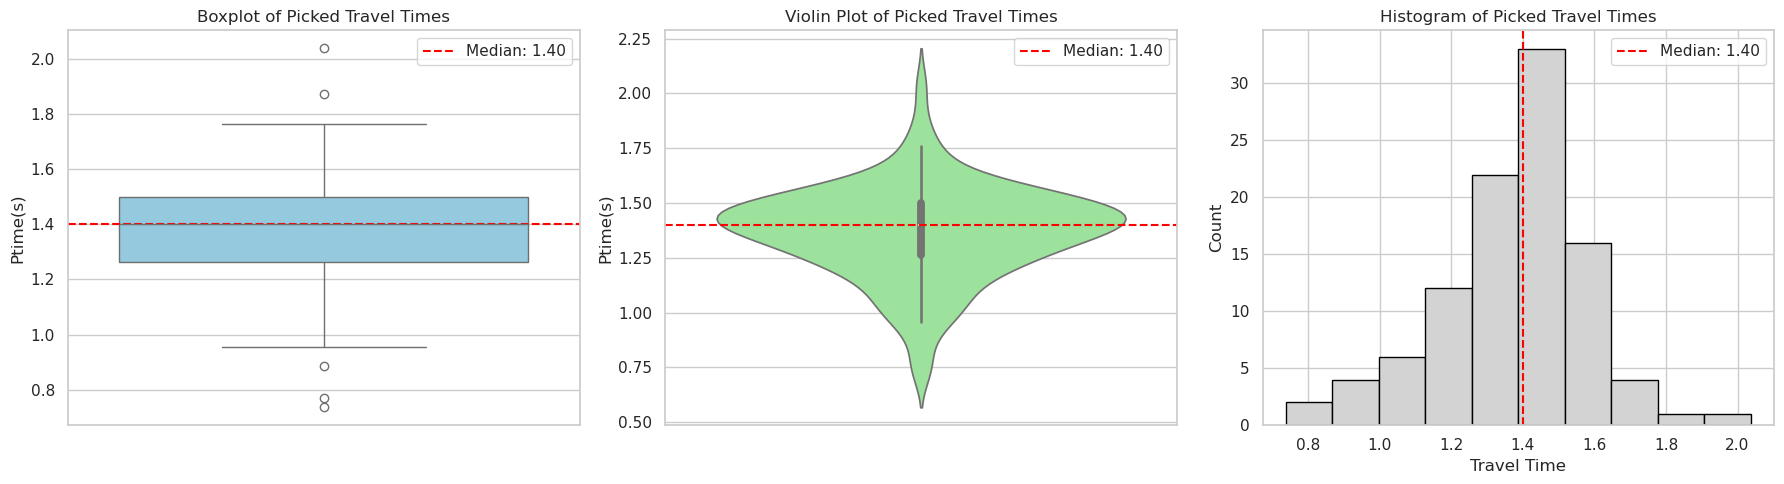

In [91]:
#visualise distribution for one station-quarry pair
import matplotlib.pyplot as plt
import seaborn as sns

# Select the row(s) where 'count' is the maximum value
df = quarry_data_group[quarry_data_group['count'] == quarry_data_group['count'].max()]
#df = pd.DataFrame([quarry_data_group.iloc[0]])
#print(df)
# Explode the 'Ptime(s)' list into individual rows for plotting
df_exploded = df.explode('Ptime(s)').reset_index(drop=True)
df_exploded['Ptime(s)'] = df_exploded['Ptime(s)'].astype(float)
# Extract the list of travel times from the 'Ptime(s)' column for median
median_value = np.median(df_exploded['Ptime(s)'])
# Set seaborn style
sns.set(style='whitegrid')

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot
sns.boxplot(y='Ptime(s)', data=df_exploded, ax=axes[0], color='skyblue')
axes[0].axhline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')
axes[0].set_title('Boxplot of Picked Travel Times')
axes[0].legend()

# Violin plot
sns.violinplot(y='Ptime(s)', data=df_exploded, ax=axes[1], inner='box', color='lightgreen')
axes[1].axhline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')
axes[1].set_title('Violin Plot of Picked Travel Times')
axes[1].legend()

# Histogram
axes[2].hist(df_exploded['Ptime(s)'], bins=10, color='lightgrey', edgecolor='black')
axes[2].axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')
axes[2].set_title('Histogram of Picked Travel Times')
axes[2].set_xlabel('Travel Time')
axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.show()

coast [WARNING]: Option -D: Unknown modifier 1 [Defaults to -Dl]


2057   -6.502024
Name: quarry-lon, dtype: float64


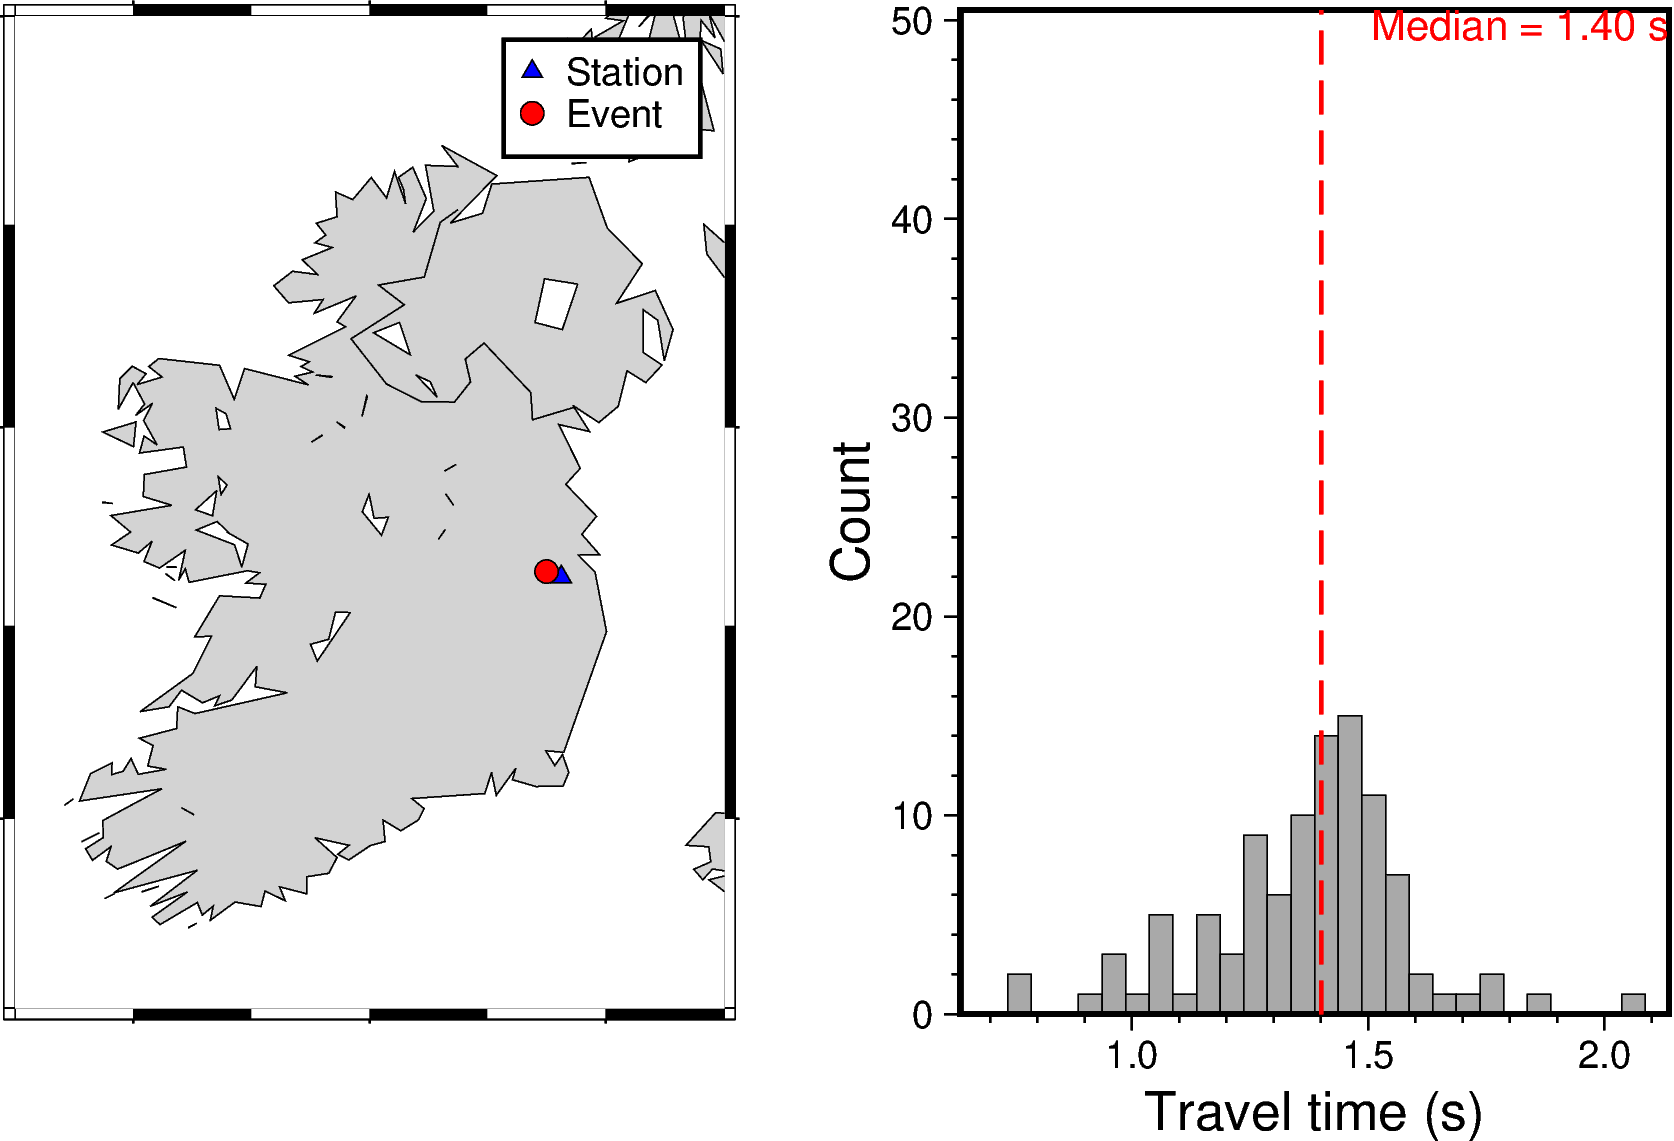

In [92]:
import pygmt

region = [-11, -5, 51, 56]
#print(df['sta'])
station_name = df['sta'].iloc[0] if hasattr(df['sta'], 'iloc') else df['sta']
station_info = stations.loc[stations['name'] == station_name].squeeze()
print(df['quarry-lon'])

# Start figure with subplots
fig = pygmt.Figure()
with fig.subplot(nrows=1, ncols=2, figsize=("14c", "8.5c"), frame="lrtb", margins=["1c", "0c"]):

    # === Panel 1: Map ===
    with fig.set_panel(panel=0):
        fig.basemap(region=region, projection="M?")
        fig.coast(land="lightgray", water="white", shorelines=True, borders=1, resolution="10m")

        # Plot event and station
        fig.plot(x=station_info['lon'], y=station_info['lat'], style="t0.2c", fill="blue", pen="black", label="Station")
        fig.plot(x=df['quarry-lon'], y=df['quarry-lat'], style="c0.2c", fill="red", pen="black", label="Event")
        #fig.plot(x=[station_info['lon'], df['quarry-lon']], y=[station_info['lat'], df['quarry-lat']], pen="1p,black,dashed")

        #fig.legend(position="JTL+o0.2c", box=True)

    # === Panel 2: Histogram ===
    with fig.set_panel(panel=1):
        fig.basemap(region=[df_exploded['Ptime(s)'].min()-0.1, df_exploded['Ptime(s)'].max()+0.1, 0, len(df_exploded)/2], 
                    projection="X?")
        fig.histogram(data=df_exploded['Ptime(s)'], frame=["xaf+lTravel time (s)", "yaf+lCount"], series = 0.05,fill="darkgray", pen="black")

        # Mark median
        median = df_exploded['Ptime(s)'].median()
        fig.plot(x=[median, median], y=[0, len(df_exploded)], pen="1p,red,dashed")
        fig.text(text=f"Median = {median:.2f} s", position='TR', font="10p,Helvetica,red")

# End figure
fig.subplot(end=True)
fig.show()


In [34]:
#group events to have a station list for each quarry
quarry_data_ev = quarry_data_group.groupby(['closest-ev_id','quarry-lat','quarry-lon','origin_time','mag']).agg({'sta': list, 'closest-time': list}).reset_index()
quarry_data_ev['count'] = quarry_data_group['sta'].apply(lambda x: len(x))
quarry_data_ev.to_csv(f'{seisblast_files}/seisblast/uniq_quarry-station_list.csv', index=False)
quarry_data_ev

,closest-ev_id,quarry-lat,quarry-lon,origin_time,mag,sta,closest-time,count
0,dias2013kwhe,54.3797,-7.378597,2013-06-04 11:58:42.744,1.29,"[D34, DL31, IDGL, UCRUI]","[13.873, 10.696, 13.043, 16.183]",4
1,dias2013kwks,52.8995,-9.038942,2013-06-04 13:45:39.377,1.56,"[IA002, IA009, IAD01, UCAR3, UD10, UGAL1, VAL]","[27.592, 18.393, 3.43, 12.756, 35.399, 24.536,...",4
2,dias2013kwle,53.4341,-7.138017,2013-06-04 14:00:17.523,1.18,[UCD11],[10.823],4
3,dias2013kwlj,52.5985,-7.200083,2013-06-04 14:05:07.330,1.16,[UHELL],[15.765],4
4,dias2013kwls,53.3092,-9.007666,2013-06-04 14:16:21.183,1.71,"[DSB, IA009, IA013, IAD01, UCAR2, UD01, UD02]","[28.79, 10.624, 21.342, 10.326, 10.139, 29.416...",3
...,...,...,...,...,...,...,...,...
2499,dias2024yqnt,54.9011,-6.278509,2024-12-16 13:58:48.159,0.82,"[CLGH, DGL2, GAL1, LAWE]","[4.04, 22.123, 17.111, 26.181]",5
2500,dias2024yslh,53.3092,-9.007666,2024-12-17 15:00:59.257,0.83,[IGLA],[4.6],4
2501,dias2024yucz,53.5524,-8.184939,2024-12-18 13:06:00.173,0.97,[ITIP],[9.762],4
2502,dias2024yvyj,52.9731,-7.522619,2024-12-19 13:01:29.362,0.96,[IBMH],[16.37],4
